In [1]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [2]:
# export
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.evaluation import *

from decode_fish.funcs.visualization import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

import h5py
from decode_fish.funcs.routines import *

initialize(config_path="../config")

hydra.initialize()

## Generate Data for comparison with ISTDECO

In [160]:
cfg = OmegaConf.load(f'../config/experiment/sim_2d_1.yaml')

crop_sz = 128
cfg.training.bs = 10
cfg.sim.random_crop.crop_sz = crop_sz
cfg.data_path.image_sim.image_shape = [1,16,1,crop_sz,crop_sz]
_, decode_dl = get_dataloader(cfg)
_, noise, micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 128, 128)
1 volumes


In [161]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [23]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/'

densities = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
intensities = [1.]
# intensities = [0.8, 0.4, 0.2, 0.12]

In [24]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *

gt_col = []
    
for d in densities:
    for i in intensities:

        k = f'dens_{d}_int_{i}'
        print(k)

        with h5py.File(out_dir+k+'.h5', 'w') as f:

            with torch.no_grad():

                ret_dict = next(iter(decode_dl))
                x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background']
                sim_vars = PointProcessUniform(local_rate[:,0]*0 + d, cfg.genm.intensity_dist.int_conc*i, cfg.genm.intensity_dist.int_rate, 
                                               cfg.genm.intensity_dist.int_loc, channels=16, n_bits=4, sim_z=False, codebook=torch.tensor(codebook), int_option=1).sample(from_code_book=True)
                ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1]))
                xsim = micro(*ch_inp)
                xsimn = micro.noise(xsim, background).sample()

                gt_vars = sim_vars[:-2]
                gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])

            gt_df = px_to_nm(gt_df)
            gt_df = exclude_borders(gt_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

            add_df_to_hdf5(f, 'locations', gt_df)          
            f.create_dataset('frames', data=cpu(xsimn))

dens_0.01_int_1.0
dens_0.025_int_1.0
dens_0.05_int_1.0
dens_0.075_int_1.0
dens_0.1_int_1.0
dens_0.125_int_1.0
dens_0.15_int_1.0
dens_0.2_int_1.0


In [154]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/'
files = glob.glob(out_dir+'/*.h5')
base_str = 'bsub -gpu "num=1" -q gpu_rtx -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_sim_eval.py '

with open('run_slurm.sh', 'w') as f:
    for n in files:
        name = n.split('/')[-1]
        print(name)
        f.write(base_str + f'data_file={name}' + ' \n')

dens_0.075_int_1.0.h5
dens_0.15_int_1.0.h5
dens_0.2_int_1.0.h5
dens_0.025_int_1.0.h5
dens_0.125_int_1.0.h5
dens_0.1_int_1.0.h5
dens_0.01_int_1.0.h5
dens_0.05_int_1.0.h5


In [155]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/'
intensities = [1]
files = glob.glob(out_dir+'sim_2d_1/*')

with h5py.File(files[0], 'a') as f:
    print(f.keys())

<KeysViewHDF5 ['high:0.2', 'istdeco', 'seed:0']>


In [156]:
densities = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
intensities = [1.0]

with h5py.File(files[0], 'r') as f:
    mod_keys = list(f.keys())

jacs = {k:np.zeros([len(intensities), len(densities)]) for k in mod_keys}

for f in files:
    with h5py.File(f, 'r') as h:
        for m in mod_keys:

            k = f.split('/')[-1].split('.h5')[0] 
            d = k.split('_')[1]
            i = k.split('_')[3]

            perf = get_df_from_hdf5(h[m]['perf'])
            
            if float(i) in intensities:
                jacs[m][intensities.index(float(i)),densities.index(float(d))] = perf['jaccard'].values[0]
            
            if k == 'dens_0.1_int_1.0':
                print(m)
                display(perf)

high:0.2


,eff_3d,jaccard,n_matches,precision,recall,rmse_vol,rmse_x,rmse_y,rmse_z
0,88.438404,0.927453,13155,0.98201,0.943484,18.004499,11.883888,13.525353,0.0


istdeco


,eff_3d,jaccard,n_matches,precision,recall,rmse_vol,rmse_x,rmse_y,rmse_z
0,54.343206,0.730987,11736,0.847487,0.841713,73.779782,52.096975,52.243291,0.0


seed:0


,eff_3d,jaccard,n_matches,precision,recall,rmse_vol,rmse_x,rmse_y,rmse_z
0,83.425831,0.875958,12570,0.968637,0.901528,21.98539,14.5084,16.518586,0.0


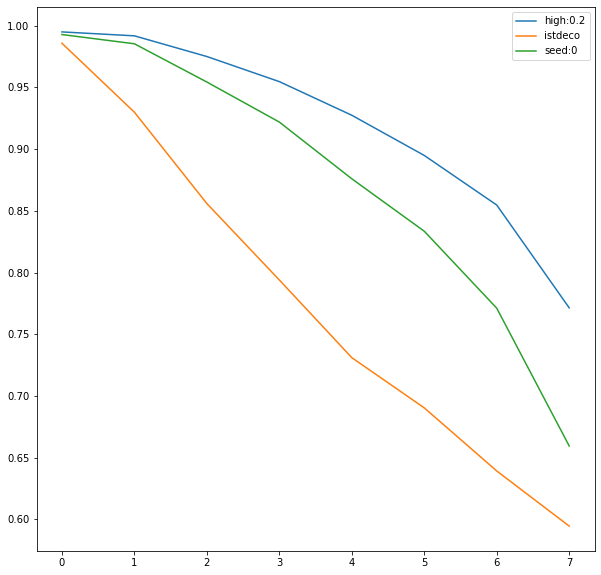

In [157]:
for i in range(len(intensities)):
    plt.figure(figsize=(10,10))
    for m in mod_keys:
        plt.plot(jacs[m][i], label=m)
    plt.legend()
    plt.show()

In [181]:
density = densities[3]
cfg = OmegaConf.load(f'../config/experiment/sim_2d_1.yaml')
codebook, targets = hydra.utils.instantiate(cfg.codebook)

with h5py.File(files[0], 'r') as f:
    mod_keys = list(f.keys())
    
with h5py.File(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/dens_{density}_int_1.0.h5', 'r') as f:

    gt_df = get_df_from_hdf5(f['locations'])

for f in [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/sim_2d_1/dens_{density}_int_1.0.h5']:
    with h5py.File(f, 'r') as h:

        dec_df = get_df_from_hdf5(h['high:0.2']['locations'])
        ist_df = get_df_from_hdf5(h['istdeco']['locations_raw'])
        ist_df['loc_idx'] = np.arange(len(ist_df))
        
        perf, matches, _ = matching(gt_df, dec_df, tolerance=500, print_res=True, match_genes=True, allow_multiple_matches=False)
        dec_df.loc[:, 'class'] = 1
        dec_df.loc[dec_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
        dec_df = sel_int_ch(dec_df, codebook)
        
        perf, matches, _ = matching(gt_df, ist_df, tolerance=500, print_res=True, match_genes=True, allow_multiple_matches=False)
        ist_df.loc[:, 'class'] = 1
        ist_df.loc[ist_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0

Recall: 0.965
Precision: 0.989
Jaccard: 95.453
RMSE_vol: 11.458
Eff_3d: 92.686
FN: 369.0 FP: 111.0
Num. matches: 10077.000
Shift: 0.35,0.10,0.00
Recall: 0.978
Precision: 0.403
Jaccard: 39.964
RMSE_vol: 52.005
Eff_3d: 34.575
FN: 226.0 FP: 15127.0
Num. matches: 10220.000
Shift: -0.05,0.31,0.00


(0.0, 100.0)

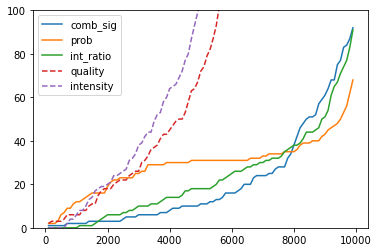

In [183]:
for k in ['comb_sig','prob','int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(dec_df, k, n_max=10000, ascending=b)
    plt.plot(r[0],r[1], label=k)

# for k in ['quality','intensity']:
#     r  = make_roc(ist_df, k, n_max=10000, ascending=False)
#     plt.plot(r[0],r[1], label=k)

tra = ist_df[ist_df['intensity'] > 7000]
for k in ['quality','intensity']:
    r  = make_roc(tra, k, n_max=10000, ascending=False)
    plt.plot(r[0],r[1], label=k, linestyle='--')
    
plt.legend()
plt.ylim(0,100)

## Generate Data for internal comparison

In [3]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_MOp"])
# cfg = OmegaConf.create(cfg)

In [11]:
thetas = 2.
channel_facs = [1.] * 22

cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_scaled_images151.tif'

cfg.genm.foci.n_foci_avg = 0

cfg.genm.prob_generator.low = 0.02
cfg.genm.prob_generator.high = 0.05

cfg.genm.noise.theta = thetas
cfg.genm.microscope.ch_facs = channel_facs
cfg.genm.microscope.col_shifts_enabled = False

cfg.sim.roi_mask.percentile = 20
cfg.sim.random_crop.crop_sz = 512

cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9
cfg.sim.bg_estimation.type = 'smoothing'

cfg.genm.intensity_dist.int_conc = 4
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = .1

cfg.genm.microscope.scale = 500
cfg.genm.phasing = 0.0
cfg.sim.bg_estimation.fractal.scale = 0

cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/chall_ds_psf.tif'
cfg.genm.microscope.norm = 'none'

cfg.genm.emitter_noise.rate_fac = 3.
cfg.genm.emitter_noise.int_fac = 1.

cfg.network.is_2D = True

In [12]:
psf, noise, micro = load_psf_noise_micro(cfg)

In [13]:
state_dict = micro.state_dict()
state_dict['channel_shifts'] = torch.randn(micro.channel_shifts.shape) * 0.2
micro.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_2/'
# !mkdir '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_2/'

In [15]:
cfg.training.bs = 1
_, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 512, 512)
7 volumes


In [16]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [25]:
from decode_fish.funcs.routines import *

xsim, cols, gt_df = sim_data(decode_dl, micro, 10, 
                          int_conc=cfg.genm.intensity_dist.int_conc, int_rate=cfg.genm.intensity_dist.int_rate, int_loc=cfg.genm.intensity_dist.int_loc,
                          channels=22, n_bits=4, codebook=torch.tensor(codebook), rate_fac=1., 
                          pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z, 
                          emitter_noise_rate_fac=cfg.genm.emitter_noise.rate_fac, emitter_noise_int_fac=cfg.genm.emitter_noise.int_fac
                         )

gt_df = px_to_nm(gt_df)
gt_df = exclude_borders(gt_df, border_size_zyx=[0,500,500], img_size=[cfg.sim.random_crop.crop_sz*100,cfg.sim.random_crop.crop_sz*100,cfg.sim.random_crop.crop_sz*100])

In [26]:
channel_facs = torch.randn(micro.channel_facs.shape) * 0.15 + 1

In [28]:
xsim = xsim / channel_facs[None,:,None,None,None].cuda()

In [29]:
state_dict = micro.state_dict()
state_dict['channel_facs'] = channel_facs
micro.load_state_dict(state_dict)

<All keys matched successfully>

In [30]:
torch.save(micro.state_dict(), out_dir+'microscope.pkl')

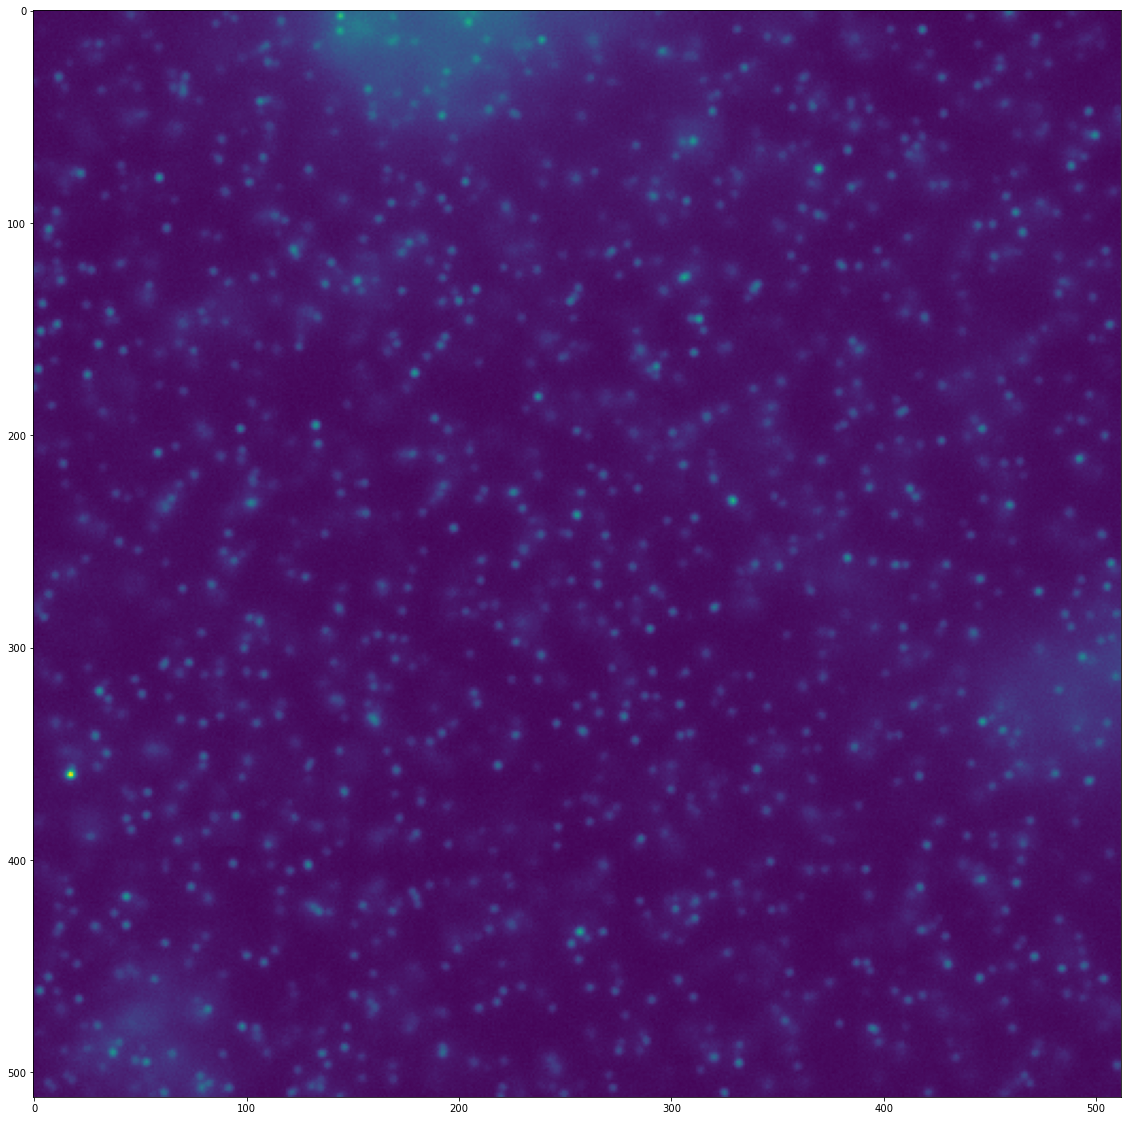

In [243]:
plt.figure(figsize=(20,20))
plt.imshow(cpu(xsim[3,11,0]))

In [35]:
# with h5py.File(out_dir+'images.h5', 'w') as f:
    
#     add_df_to_hdf5(f, 'locations', gt_df)          
#     f.create_dataset('frames', data=cpu(xsim))

# import tifffile
# tifffile.imsave(out_dir+'images.tiff', data=cpu(xsim))

In [36]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_2/'
with h5py.File(out_dir+'images.h5', 'r') as f:
    
    gt_df = get_df_from_hdf5(f['locations'])  
    frames = f['frames'][()]

In [320]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_2/ae_train_2////train.yaml')

In [321]:
cfg_files = [cstr for cstr in cfg_files if '9900' not in cstr] 

In [310]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [322]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
# psf_init = cpu(micro.psf_init_vol)
post_proc.codebook = torch.tensor(codebook)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
10 volumes


0.847901834445029
0.9935754086476731
0.9865559445295577
0.3713411923772839


Text(0.5, 0, 'Round')

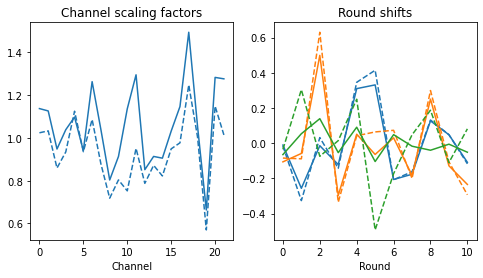

In [323]:
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8, 4))
cmap = sns.color_palette("tab10")

ax1.plot(cpu(micro_init.channel_facs), color=cmap[0], linestyle='--')
ax1.plot(cpu(micro.channel_facs), color=cmap[0])
ax1.set_title('Channel scaling factors')
ax1.set_xlabel('Channel')
print(np.corrcoef(cpu(micro.channel_facs), cpu(micro_init.channel_facs))[0,1])

labels = ['x','y','z']
for i in range(3):
    ax2.plot(cpu(micro.channel_shifts[:,i]), label=labels[i], color=cmap[i])
    ax2.plot(cpu(micro_init.channel_shifts[:,i] - micro_init.channel_shifts[:,i].mean()), label=labels[i], linestyle='--', color=cmap[i])
    print(np.corrcoef(cpu(micro.channel_shifts[:,i]), cpu(micro_init.channel_shifts[:,i]))[0,1])
ax2.set_title('Round shifts')
ax2.set_xlabel('Round')

In [204]:
gt_psf = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/chall_ds_psf.tif')

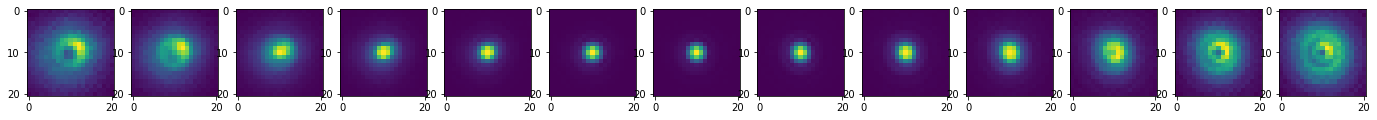

In [304]:
f, axes = plt.subplots(1, len(gt_psf), sharey=False, figsize=(24,4))
for n in range(len(gt_psf)):

    axes[n].imshow(gt_psf[n])

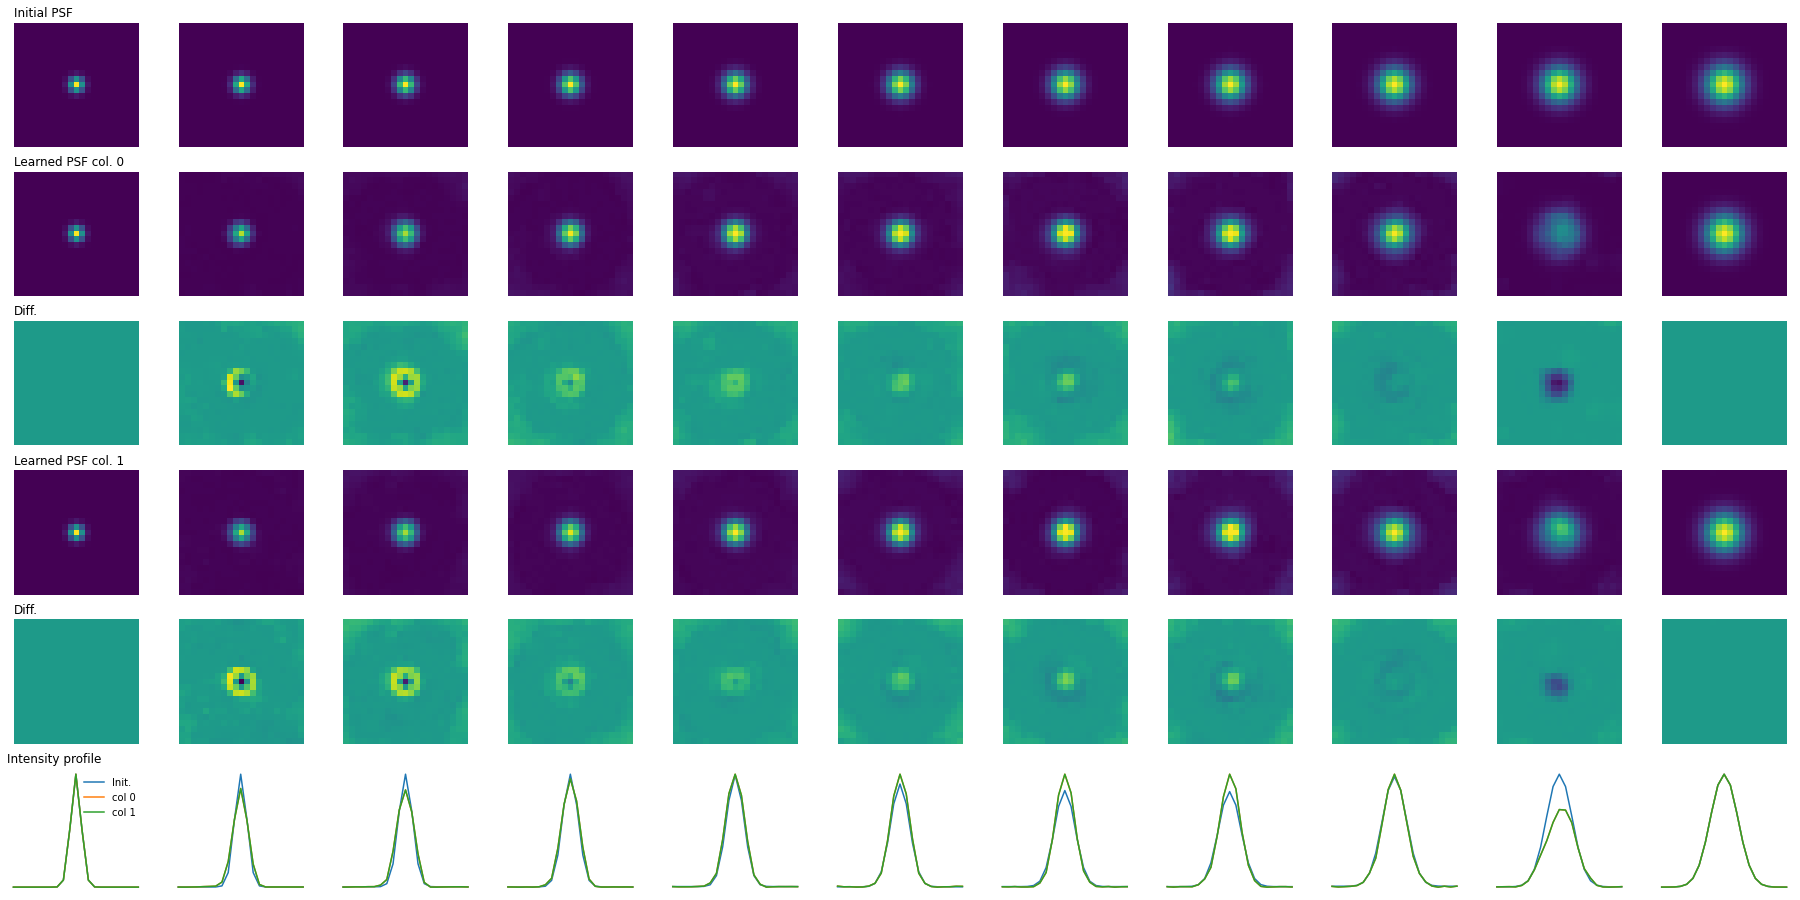

In [305]:
plot_slice_psf_pars(micro)

In [326]:
cfg_files = glob.glob(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_2/*/train.yaml')
cfg_files = [cstr for cstr in cfg_files if '9900' not in cstr and 'unibg' not in cstr] 

In [347]:
from decode_fish.funcs.predict import window_predict
# df_dict = {}
for file in cfg_files:
    k = file.split('/')[-2]
#     if k not in df_dict:
    cfg = OmegaConf.load(file)
    model = load_model_state(model, Path(cfg.output.save_dir)/'model.pkl').cuda()
    psf, noise, micro = load_psf_noise_micro(cfg)
    micro.load_state_dict(torch.load(Path(cfg.output.save_dir)/'microscope.pkl'))
    res_df = window_predict(model, post_proc, decode_dl.dataset.volumes, window_size=[None, 128, 128], device='cuda', chrom_map=None, scale=micro.get_ch_mult(), progress_bar=True)
    res_df = exclude_borders(res_df, border_size_zyx=[0,500,500], img_size=[512*100,512*100,512*100])  
    df_dict[k] = res_df

ae_train_2
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.60s/it]


ae_train_2 0.44684035428342994
channel_facs:False 0.39695054764601706
psf_vol:False 0.3624510580827106
ae_train 0.4714874407427124
sl_true_gen 0.03734049624854695
channel_shifts:False 0.3120487300116676
sl_nolearn 0.29300467137332326


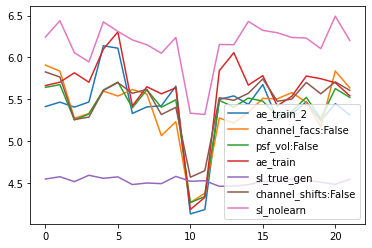

In [340]:
for k in df_dict:
    int_arr = zero_int_ch(df_dict[k].nsmallest(15000, 'comb_sig'), codebook)[[f'int_{i}' for i in range(codebook.shape[1])]].values
    ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
    print(k, np.sqrt(np.var(ch_means)))
    
    plt.plot(ch_means, label=k)
plt.legend()

ae_train_2 0.19521868143231563
channel_facs:False 0.6380227925312525
psf_vol:False 0.15500432315778617
ae_train 0.18554928866803166
sl_true_gen 0.03734049624854695
channel_shifts:False 0.12147351674268088
sl_nolearn 0.6092481699538415


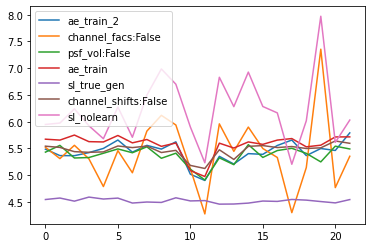

In [348]:
for k in df_dict:
    int_arr = zero_int_ch(df_dict[k].nsmallest(15000, 'comb_sig'), codebook)[[f'int_{i}' for i in range(codebook.shape[1])]].values
    ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
    print(k, np.sqrt(np.var(ch_means)))
    
    plt.plot(ch_means, label=k)
plt.legend()

In [283]:
int_arr = zero_int_ch(df_dict['ae_train'].nsmallest(15000, 'comb_sig'), codebook)[[f'int_{i}' for i in range(codebook.shape[1])]].values
ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
print(k, np.sqrt(np.var(ch_means)))

sl_nolearn 0.18554928866803166


In [349]:
for k in df_dict.keys():
    print(k, len(df_dict[k]))

ae_train_2 37628
channel_facs:False 41558
psf_vol:False 47137
ae_train 41197
sl_true_gen 42648
channel_shifts:False 38286
sl_nolearn 54816


In [350]:
perf_df = pd.DataFrame()

for k in df_dict.keys():

    perf, matches, _ = matching(gt_df, df_dict[k], print_res=False, tolerance=500, ignore_z=True)
    df_dict[k].loc[:, 'class'] = 1
    df_dict[k].loc[df_dict[k]['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0    
    
    perf_df[k] = pd.Series(perf)

(0.0, 2000.0)

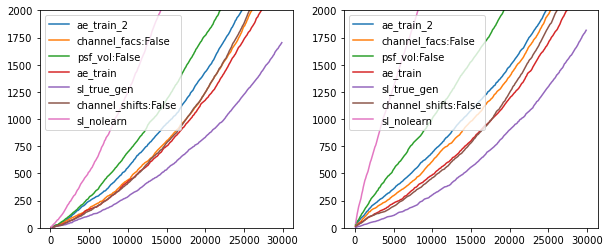

In [351]:
plt.figure(figsize=(10,4))
plt.subplot(121)
for k in df_dict:    
    df_c = df_dict[k].copy()
    df_c = sel_int_ch(df_c, codebook)
    r  = make_roc(df_c, 'comb_sig', n_max=30000, ascending=True)
    plt.plot(r[0],r[1], label=k)

plt.legend()
plt.ylim(0,2000)

plt.subplot(122)
for k in df_dict:    
    df_c = df_dict[k].copy()
    df_c = sel_int_ch(df_c, codebook)
    r  = make_roc(df_c, 'int_ratio', n_max=30000, ascending=True)
    plt.plot(r[0],r[1], label=k)

plt.legend()
plt.ylim(0,2000)

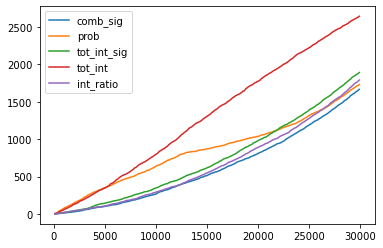

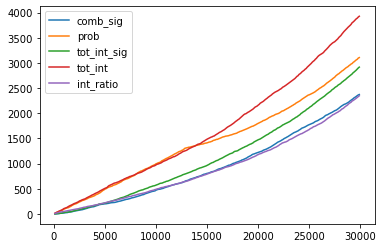

In [192]:
df_c = sel_int_ch(df_dict['sl_true_gen'], codebook)

for k in ['comb_sig','prob','tot_int_sig','tot_int', 'int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(df_c, k, n_max=30000, ascending=b)
    plt.plot(r[0],r[1], label=k)
    
plt.legend()
plt.show()
df_c = sel_int_ch(df_dict['ae_train'], codebook)

for k in ['comb_sig','prob','tot_int_sig','tot_int', 'int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(df_c, k, n_max=30000, ascending=b)
    plt.plot(r[0],r[1], label=k)
    
plt.legend()

In [249]:
perf, matches, _ = matching(gt_df, df_dict['channel_shifts:False'], print_res=False, tolerance=200, ignore_z=True)
# perf

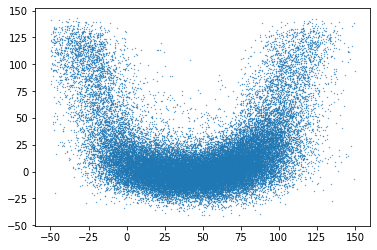

In [247]:
plt.scatter(matches['z_tar'], matches['z_pred'], s=0.1)

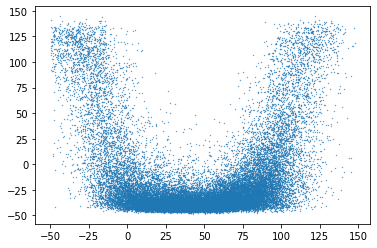

In [250]:
plt.scatter(matches['z_tar'], matches['z_pred'], s=0.1)

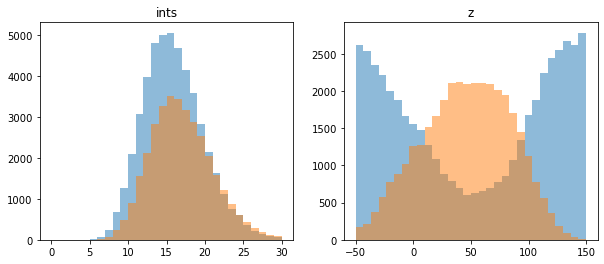

In [245]:
gt_df.loc[:, 'class'] = 1
gt_df.loc[gt_df['loc_idx'].isin(matches['loc_idx_tar']), 'class'] = 0

metrics = ['ints','z']
bins = [np.linspace(0,30,31), np.linspace(-50,150.,31)]
plt.figure(figsize=(10,4))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(gt_df[gt_df['class'] == 1][metrics[i]], density=False, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(gt_df[gt_df['class'] == 0][metrics[i]], density=False, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

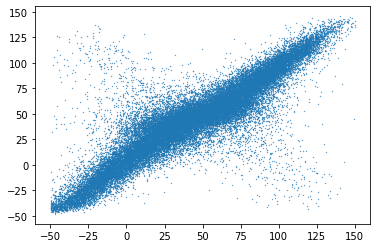

In [227]:
plt.scatter(matches['z_tar'], matches['z_pred'], s=0.1)

In [53]:
# from decode_fish.funcs.routines import *
from decode_fish.funcs.routines import *
xsim, cols, gt = sim_data(decode_dl, micro, 5, 
                          int_conc=model.int_dist.int_conc.detach(), int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(),
                          channels=22, n_bits=4, codebook=torch.tensor(codebook), rate_fac=1., 
                          pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z, 
                          emitter_noise_rate_fac=cfg.genm.emitter_noise.rate_fac, emitter_noise_int_fac=cfg.genm.emitter_noise.int_fac
                         )

In [54]:
pred_dfs = []
net_inp = torch.concat([xsim], 1)
for i in range(len(net_inp)):
    pred_df = get_prediction(model, net_inp[i:i+1], post_proc, cuda=True)
    pred_dfs.append(pred_df)

pred_df = cat_emitter_dfs(pred_dfs)

In [55]:
perf, matches, _ = matching(px_to_nm(gt, cfg.evaluation.px_size_zyx), pred_df, tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

Recall: 0.402
Precision: 0.903
Jaccard: 38.582
RMSE_vol: 63.369
Eff_3d: 30.891
FN: 3281.0 FP: 237.0
Num. matches: 2210.000
Shift: 0.80,0.19,-1.13
